In [1]:
import pandas as pd

# Load Exported Data

Given we have called the theyvoteforyou.org.au api, and saved the list of members to a csv we can import it.


In [2]:
members_df = pd.read_csv("01_extract_they_vote_for_you/output.csv")

members_df.head()

,id,latest_member.id,latest_member.name.first,latest_member.name.last,latest_member.electorate,latest_member.house,latest_member.party
0,10007,6,Anthony,Albanese,Grayndler,representatives,Australian Labor Party
1,10014,13,Kevin,Andrews,Menzies,representatives,Liberal Party
2,10043,40,Sharon,Bird,Cunningham,representatives,Australian Labor Party
3,10081,69,Tony,Burke,Watson,representatives,Australian Labor Party
4,10088,74,Anthony,Byrne,Holt,representatives,Australian Labor Party


In [3]:
members_df.shape

(227, 7)

# Clean Up Columns

Given we have two potential identifying columns: 
* `id`
* `latest_member.id`

Let's confirm if they are actually unique and then keep one of them.

In [4]:
for col in ["id", "latest_member.id"]:
    is_unique = members_df[col].is_unique
    print(col, is_unique)

id True
latest_member.id True


We could refer back to the API Docs to understand the signifigance of the two ID-like columns.
However we will just drop the `id` column and keep `latest_member.id`

In [5]:
members_df = members_df.drop(["id"], axis = 1)
members_df.head()

,latest_member.id,latest_member.name.first,latest_member.name.last,latest_member.electorate,latest_member.house,latest_member.party
0,6,Anthony,Albanese,Grayndler,representatives,Australian Labor Party
1,13,Kevin,Andrews,Menzies,representatives,Liberal Party
2,40,Sharon,Bird,Cunningham,representatives,Australian Labor Party
3,69,Tony,Burke,Watson,representatives,Australian Labor Party
4,74,Anthony,Byrne,Holt,representatives,Australian Labor Party


Let's normalise the column names - for example `latest_member.name.first` will become `name_first` - dropping `latest_member` from the column names and replacing `.` with `_`.

In [7]:
new_columns = [str(x).replace("latest_member.", "") for x in members_df.columns]
new_columns = [x.replace(".", "_") for x in new_columns]
new_columns

['id', 'name_first', 'name_last', 'electorate', 'house', 'party']

In [8]:
members_df.columns = new_columns
members_df.head()

,id,name_first,name_last,electorate,house,party
0,6,Anthony,Albanese,Grayndler,representatives,Australian Labor Party
1,13,Kevin,Andrews,Menzies,representatives,Liberal Party
2,40,Sharon,Bird,Cunningham,representatives,Australian Labor Party
3,69,Tony,Burke,Watson,representatives,Australian Labor Party
4,74,Anthony,Byrne,Holt,representatives,Australian Labor Party


# DataType Checks

Based on a sample of the dataset, I assume that following datatypes exist:
* id - integer
* name_first - string
* name_last - string
* electorate - string
* house - string
* party - string

In [9]:
members_df.dtypes

id             int64
name_first    object
name_last     object
electorate    object
house         object
party         object
dtype: object

# NULL Value Checks

By using pandas.describe and making it produce stats for all columns (not just numeric types) we can quickly confirm that there are values for every observation.

In [11]:
members_df.describe(include="all").loc["count"]

id            227
name_first    227
name_last     227
electorate    227
house         227
party         227
Name: count, dtype: object

It appears there are values in every column in every observation

# Distribution Checks

## Party

I assume that the breakdown by party will approximately 40% / 40% / 20% for Labor / Liberal / (others)


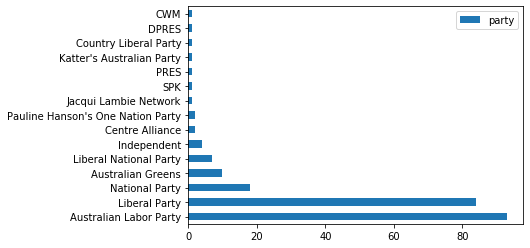

In [12]:
pd.DataFrame(members_df["party"].value_counts()).plot.barh()

## House

Let's inspect the disribution of values in the `house` column

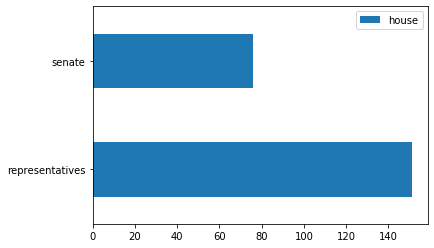

In [13]:
pd.DataFrame(members_df["house"].value_counts()).plot.barh()

This column could be modelled as two columns of:
* senate
* representatives

Where the values are `True` or `False`

# Electorate

Is this column a unique value?

In [14]:
members_df["electorate"].is_unique

False

In [15]:
electorate_count_df =  pd.DataFrame(members_df["electorate"].value_counts())
electorate_count_df = electorate_count_df.sort_values("electorate", ascending = False)
electorate_count_df

,electorate
Victoria,12
SA,12
NSW,12
WA,12
Queensland,12
...,...
Barker,1
Ryan,1
Clark,1
Hunter,1


Is there a relationship between `electorate` and `house` - because in the electorate column we seem to have two levels of geographical abstraction: State and LGA

In [16]:
house_electorate_df = members_df[["electorate", "house", "party"]].groupby(["house", "electorate"]).count()
house_electorate_df.columns = ["count"]

I suspect the senate group will have the states present

In [17]:
house_electorate_df.loc["senate"]

,count
electorate,
ACT,2
NSW,12
NT,2
Queensland,12
SA,12
Tasmania,12
Victoria,12
WA,12


I suspect the representatives level will have a max count of 1 - i.e. in the case of "house" being "representatives" the value in electorate is unique.

In [18]:
house_electorate_df.loc["representatives"]["count"].max()

1

Let's inspect the members who have an electorate that is a state

In [19]:
states = house_electorate_df.loc["senate"].index.values

In [20]:
members_df.loc[members_df["electorate"].isin(states)]

,id,name_first,name_last,electorate,house,party
151,100001,Eric,Abetz,Tasmania,senate,Liberal Party
152,100014,Simon,Birmingham,SA,senate,Liberal Party
153,100026,Carol,Brown,Tasmania,senate,Australian Labor Party
154,100036,Kim,Carr,Victoria,senate,Australian Labor Party
155,100082,Concetta,Fierravanti-Wells,NSW,senate,Liberal Party
...,...,...,...,...,...,...
222,100922,Jim,Molan,NSW,senate,Liberal Party
223,100923,Andrew,McLachlan,SA,senate,Liberal Party
224,100924,Rex,Patrick,SA,senate,Independent
225,100925,Lidia,Thorpe,Victoria,senate,Australian Greens


Given I want to map members to postcode, I will omit members who's electorate is a state

In [21]:
representatives_df = members_df.loc[~members_df["electorate"].isin(states)]

In [22]:
representatives_df.shape

(151, 6)

### Re-inspect House

In [24]:
representatives_df["house"].value_counts()

representatives    151
Name: house, dtype: int64

Given house contains redundent information let's drop it

In [25]:
representatives_df = representatives_df.drop(["house"], axis = 1)

In [26]:
representatives_df.head()

,id,name_first,name_last,electorate,party
0,6,Anthony,Albanese,Grayndler,Australian Labor Party
1,13,Kevin,Andrews,Menzies,Liberal Party
2,40,Sharon,Bird,Cunningham,Australian Labor Party
3,69,Tony,Burke,Watson,Australian Labor Party
4,74,Anthony,Byrne,Holt,Australian Labor Party


# Output Transform Records


In [27]:
representatives_df = representatives_df.set_index("id")
representatives_df.head()

,name_first,name_last,electorate,party
id,,,,
6,Anthony,Albanese,Grayndler,Australian Labor Party
13,Kevin,Andrews,Menzies,Liberal Party
40,Sharon,Bird,Cunningham,Australian Labor Party
69,Tony,Burke,Watson,Australian Labor Party
74,Anthony,Byrne,Holt,Australian Labor Party


In [28]:
representatives_df.to_csv("02_transform_they_vote_for_you/output.csv", index = True)